# How to slice and dice the data
Below are a series of examples on how to slide and dice data from the SQLite database file that is created by the scraper. 

### Required Modules and matplotlib backend

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib

In [16]:

from importlib import reload
import pandas as pd
import numpy as np

# Import dataframe module from project folder.
# This module contains a class that reads data from database 
# tables and assign it to a DataFrame object
import dataframes
reload(dataframes)

<module 'dataframes' from '/home/cbrandao/lib/python/equiTable/dataframes.py'>

In [15]:
df = dataframes.DataFrames('db/mstables2.sqlite')

Creating intial DataFrames ...
Creating DataFrame 'colheaders' ...
Creating DataFrame 'timerefs' ...
Creating DataFrame 'urls' ...
Creating DataFrame 'types' ...
Creating DataFrame 'tickers' ...
Creating DataFrame 'sectors' ...
Creating DataFrame 'industries' ...
Creating DataFrame 'stockstyles' ...
Creating DataFrame 'exchanges' ...
Creating DataFrame 'countries' ...
Creating DataFrame 'companies' ...
Creating DataFrame 'currencies' ...
Creating DataFrame 'companytypes' ...
Creating DataFrame 'master' ...
Initial DataFrames created.


In [17]:
df_mtr = df.master

In [8]:
df_mtr.head() #.drop(['ticker_id', 'exchange_id'], axis=1)

,ticker_id,exchange_id,country,country_name,exchange_symbol,exchange,ticker,company,type_code,type,sector,industry,fy_end,updated
37947,234443,18,GBR,United Kingdom,XLON,LONDON STOCK EXCHANGE,ETX,e-Therapeutics PLC,ST,Stock,Healthcare,Biotechnology,2020-01-31,2019-03-09
60534,1016947,17,DEU,Germany,XBER,BOERSE BERLIN,NVD,NVIDIA Corp,ST,Stock,Technology,Semiconductors,2020-01-27,2019-03-11
60533,1016947,16,DEU,Germany,XFRA,DEUTSCHE BOERSE AG,NVD,NVIDIA Corp,ST,Stock,Technology,Semiconductors,2020-01-27,2019-03-11
60540,16668,575,ITA,Italy,XMIL,BORSA ITALIANA S.P.A.,NVDA,NVIDIA Corp,ST,Stock,Technology,Semiconductors,2020-01-27,2019-03-11
60539,1016947,145,DEU,Germany,XHAM,BOERSE HAMBURG,NVD,NVIDIA Corp,ST,Stock,Technology,Semiconductors,2020-01-27,2019-03-11


### Date of Data Updates
List of dates when the data was last updated and the count of symbols updated on each.

In [9]:
print('Master Table Length = {:,.0f}'.format(len(df_mtr)))
((df_mtr[['updated', 'ticker']].groupby(by='updated').count().sort_values(by='ticker', ascending=False)
 .rename(columns={'ticker':'ticker_count'}))['ticker_count'].rename_axis('Last Updated')
 .sort_index(ascending = False))

Master Table Length = 114,735


Last Updated
2019-03-13     1211
2019-03-12    23873
2019-03-11    43937
2019-03-10    11416
2019-03-09    31413
2019-03-08     2880
2019-03-07        5
Name: ticker_count, dtype: int64

In [183]:
(df_mtr[['type', 'ticker']]
 .groupby(by='type').count()
 .sort_values(by='ticker', ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
type,
Stock,77476
Open-End Fund,25670
Exchange-Traded Fund,6271
Index,3101
Closed-End Fund,1216
Money Market Fund,1001


In [168]:
(df_mtr[['country_name', 'ticker']]
 .groupby(by='country_name').count()
 .sort_values(by='ticker', ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
country_name,
United States,53351
Germany,36831
Ireland,5076
Canada,4282
United Kingdom,4008
China,3801
Australia,2350
Hong Kong,2328
France,1231


In [172]:
# Overview of number of tickers per exchange by country (for count() > 10)
cols = ['country', 'country_name', 'exchange', 'exchange_symbol', 'ticker']

us_exchanges = (df_mtr[cols] # Select relevant columns
                #.where(df_mtr['country'] == 'USA').dropna() # Filter for country 'USA' only
                .groupby(by=cols[:-1]) # Group records by first four columns
                .count() # Count total of records per group
                .rename(columns={'ticker':'ticker_count'})) # Rename count column for readibility 

(us_exchanges.where(us_exchanges['ticker_count'] > 10).dropna()) # Filter out exchanges with less then 10 records

ticker_count
country country_name   exchange                             exchange_symbol              
AUS     Australia      ASX - ALL MARKETS                    XASX                   2350.0
BEL     Belgium        EURONEXT - EURONEXT BRUSSELS         XBRU                    192.0
CAN     Canada         AEQUITAS NEO EXCHANGE                NEOE                     63.0
                       CANADIAN NATIONAL STOCK EXCHANGE     XCNQ                    421.0
                       TORONTO STOCK EXCHANGE               XTSE                   2038.0
                       TSX VENTURE EXCHANGE                 XTSX                   1760.0
CHE     Switzerland    SIX SWISS EXCHANGE                   XSWX                    299.0
CHN     China          SHANGHAI STOCK EXCHANGE              XSHG                   1584.0
                       SHENZHEN STOCK EXCHANGE              XSHE                   2217.0
DEU     Germany        BOERSE BERLIN                        XBER                   8469.0
                       BOERSE DUESSELDORF                   XDUS                   2253.0
                       BOERSE HAMBURG                       XHAM                   1360.0
                       BOERSE HANNOVER                      XHAN                    462.0
                       BOERSE MUENCHEN                      XMUN                   4871.0
                       BOERSE STUTTGART                     XSTU                   8402.0
                       DEUTSCHE BOERSE AG                   XFRA                  11013.0
FRA     France         EURONEXT - EURONEXT PARIS            XPAR                   1227.0
GBR     United Kingdom LSE International Trading Service    LTS                    3505.0
                       NEX Exchange                         NEXX                    503.0
HKG     Hong Kong      HONG KONG EXCHANGES AND CLEARING LTD XHKG                   2328.0
IRL     Ireland        LONDON STOCK EXCHANGE                XLON                   3512.0
                       XETRA                                XETR                   1560.0
ITA     Italy          BORSA ITALIANA S.P.A.                XMIL                    633.0
LUX     Luxembourg     SINGAPORE EXCHANGE                   XSES                     18.0
NLD     Netherlands    EURONEXT - EURONEXT AMSTERDAM        XAMS                    232.0
                       TOKYO STOCK EXCHANGE                 XTKS                     24.0
PRT     Portugal       EURONEXT - EURONEXT LISBON           XLIS                     66.0
USA     United States  BATS Z-EXCHANGE                      BATS                    291.0
                       Dow Jones Indices                    DJI                     174.0
                       NASDAQ                               XNAS                  29914.0
                       NEW YORK STOCK EXCHANGE, INC.        XNYS                   2867.0
                       NYSE ARCA                            ARCX                   1570.0
                       NYSE MKT LLC                         XASE                    308.0
                       OTC GREY MARKET                      GREY                   5540.0
                       OTC MARKETS                          PINX                   9900.0
                       S&P Indices                          SPI                     172.0
                       U.S. Indexes                         IXUS                   2589.0

In [173]:
df_mtr[['sector', 'ticker']].groupby(by='sector').count().rename(columns={'ticker':'ticker_count'})

,ticker_count
sector,
Basic Materials,13012
Communication Services,38868
Consumer Cyclical,9740
Consumer Defensive,4190
Energy,4479
Financial Services,8709
Healthcare,8043
Industrials,10985
Real Estate,4007


In [84]:
df_val0 = df.Valuation() # P/E, P/S, P/B and P/CF ratios

In [85]:
df_val = df_mtr.merge(df_val0, on=['ticker_id', 'exchange_id']).drop(['ticker_id', 'exchange_id'], axis=1)

In [249]:
cols_val_yrs = df_val.iloc[0, 12:23]

In [296]:
(df_val[['sector', 'ticker']].groupby(by='sector').count().rename(columns={'ticker':'ticker_count'}))

,ticker_count
sector,
Basic Materials,13000
Communication Services,1612
Consumer Cyclical,9736
Consumer Defensive,4187
Energy,4476
Financial Services,8705
Healthcare,8037
Industrials,10977
Real Estate,4001


### Average Valuation Ratios by Sector for past 10 yrs
*P/E (Price / Earnings per share)*

In [290]:
val_sector_mean = df_val.groupby(by='sector').mean()

In [291]:
pe = val_sector_mean.iloc[:, 0:11]
pe.columns = cols_val_yrs

<IPython.core.display.Javascript object>


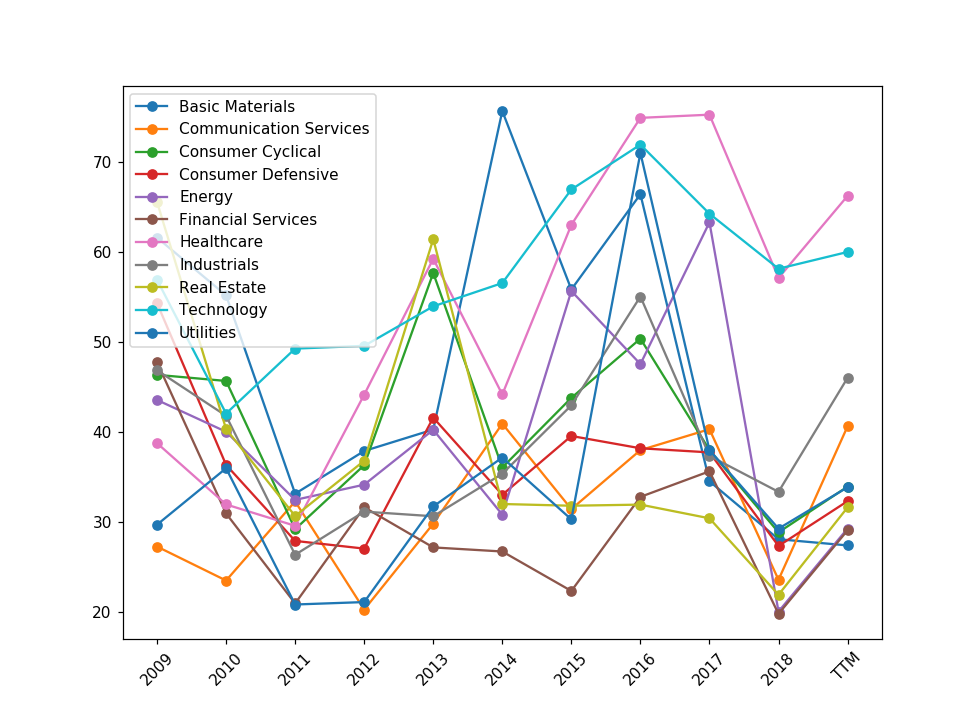

In [293]:
fig_pe, ax_pe = plt.subplots(1)
for i in range(len(pe)):
    ax_pe.plot(pe.iloc[i], ('o-'))
ax_pe.legend()
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(45)

In [186]:
val_indus_mean = df_val.groupby(by=['sector', 'industry']).mean() 

In [87]:
list(enumerate(df_val.head().columns.values.tolist()))

[(0, 'country'),
 (1, 'country_name'),
 (2, 'exchange_symbol'),
 (3, 'exchange'),
 (4, 'ticker'),
 (5, 'company'),
 (6, 'type_code'),
 (7, 'type'),
 (8, 'sector'),
 (9, 'industry'),
 (10, 'fy_end'),
 (11, 'updated'),
 (12, 'Y0'),
 (13, 'Y1'),
 (14, 'Y2'),
 (15, 'Y3'),
 (16, 'Y4'),
 (17, 'Y5'),
 (18, 'Y6'),
 (19, 'Y7'),
 (20, 'Y8'),
 (21, 'Y9'),
 (22, 'Y10'),
 (23, 'PE_Y0'),
 (24, 'PE_Y1'),
 (25, 'PE_Y2'),
 (26, 'PE_Y3'),
 (27, 'PE_Y4'),
 (28, 'PE_Y5'),
 (29, 'PE_Y6'),
 (30, 'PE_Y7'),
 (31, 'PE_Y8'),
 (32, 'PE_Y9'),
 (33, 'PE_Y10'),
 (34, 'PS_Y0'),
 (35, 'PS_Y1'),
 (36, 'PS_Y2'),
 (37, 'PS_Y3'),
 (38, 'PS_Y4'),
 (39, 'PS_Y5'),
 (40, 'PS_Y6'),
 (41, 'PS_Y7'),
 (42, 'PS_Y8'),
 (43, 'PS_Y9'),
 (44, 'PS_Y10'),
 (45, 'PB_Y0'),
 (46, 'PB_Y1'),
 (47, 'PB_Y2'),
 (48, 'PB_Y3'),
 (49, 'PB_Y4'),
 (50, 'PB_Y5'),
 (51, 'PB_Y6'),
 (52, 'PB_Y7'),
 (53, 'PB_Y8'),
 (54, 'PB_Y9'),
 (55, 'PB_Y10'),
 (56, 'PC_Y0'),
 (57, 'PC_Y1'),
 (58, 'PC_Y2'),
 (59, 'PC_Y3'),
 (60, 'PC_Y4'),
 (61, 'PC_Y5'),
 (62, 'PC_Y6

In [309]:
df = None # Set df variable to none to close db connection 